### N-Step Sarsa with Sutton Tile Encoding for feature construction

In [97]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import pandas as pd
import timeit
from tqdm import notebook
import itertools
import utility_lib.SuttonTileEncoding as stenc
# device for CUDA 
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [105]:
class TilingLFA():
    '''
    Linear Function Approximation (FA) using Tiling Feature Encoding
    (cited from Sutton and Barto, 2018)
    '''
    
    # Estimator constructor and parameters
    def __init__(self, env, step_size, n=8, max_dim=4096, k=None, et=False):
        '''Constructor for the Tiling FA estimator.

        Args:
        - step_size [Float]: Fraction of the way to the target U.
        - n [Int]: Number of tilings per state dimension. (should be power of 2 according to Sutton and Barto 2018)
        - max_size [Int]: Maximum size of the feature vector.
        - k [Int]: Tiling Dimension. 
        - et [Boolean]: Whether to use the eligibility trace.
        '''
        
        self.max_dim = max_dim
        self.n = n
        self.k = k
        self.et = et

        # alpha = step_size/num_tilings, where step_size is the fraction of the way to the target 
        self.alpha = step_size / n

        # Index hash table (IHT) for tile coding : assigns unique index to each tile up to max_dim tiles.
        # max_dim >= total number of tiles (n x k x k)
        # Used Sutton Tile Encoding for this implementation cite:[http://incompleteideas.net/tiles/tiles3.py-remove]
        self.hash = stenc.IHT(max_dim)

        # Initialize weights and eligibility trace if required
        self.weights = np.zeros(max_dim)
        if self.et:
            self.z = np.zeros(max_dim)

        # For mountain car environment, we need to scale the state (position and velocity) 
        # space to span the tiling dimension (k x k) Ref: http://incompleteideas.net/tiles/tiles3.html
        self.pos_scaling_factor = self.k / (env.observation_space.high[0] - env.observation_space.low[0])
        self.vel_scaling_factor = self.k / (env.observation_space.high[1] - env.observation_space.low[1])
        
    def get_feature_encoding(self, state, action):
        '''Function to get the tiling features for a given state and action pair.
        
        Used tiles function of Sutton's tiling implementation which takes in index table, number of tilings,
        and floats for state and ints for action.
        Args:
        - state [Array]: State vector (position and velocity).
        - action [Int]: Action index.

        Returns:
        - features [Array]: Tiling features for given state and action.
        '''
        feature_vector = stenc.tiles(self.hash, self.n, 
                           [self.pos_scaling_factor * state[0], self.vel_scaling_factor * state[1]], 
                           [action])
        return feature_vector
    
    def estimate_q(self, state, action=None):
        '''Calculates the q value with linear function approximation using tiled features.

        Args:
        - s [Array]: State vector (position and velocity).
        - a [Int]: Action index.

        Returns:
        - q [Float]: Q value for given state and action.
        '''
        # Get Q-value for all actions if action is not specified (for epsilon greedy policy)
        if action is None:
            features = [self.get_feature_encoding(state, a) for a in range(env.action_space.n)]
        else:
            features = [self.get_feature_encoding(state, action)]
        
        # just return of all the weights for which the feature vector is 1
        return [np.sum(self.weights[feature]) for feature in features]
        
            
    def update(self, state, action, target):
        '''Updating the weights and eligibility trace using the TD error.
        
        Args:
        - state [Array]: State vector (position and velocity).
        - action [Int]: Action index.
        - target [Float]: Target value.
        '''
        # Get the tiling features
        features = self.get_feature_encoding(state, action)
        q_estimate = self.estimate_q(state,action)
        delta = (target - q_estimate)
        
        if self.et:
            # Accumulating eligibility trace
            # self.z[features] += 1  
            self.z[features] = 1  # Replacing trace
            self.weights += self.alpha * delta * self.z
        else:
            # Update without eligibility trace
            self.weights[features] += self.alpha * delta
                
    
    def reset_estimator(self, only_z=False):
        '''Resets the estimator parameters
        to their initial values.

        Args:
        - z_only [Boolean]: Whether to reset only the eligibility trace.
        - et [Boolean]: Whether to use the eligibility trace.
        '''
        
        if only_z:
            assert self.et, 'no eligibility trace to reset.'
            self.z = np.zeros(self.max_dim)
        else:
            if self.et:
                self.z = np.zeros(self.max_dim)
            self.weights = np.zeros(self.max_dim)
        

In [88]:
def get_action_probs(estimator, epsilon, num_actions, state):
    '''Function to get the action probabilities for a given state using an epsilon greedy policy.

    Args:
    - estimator [Estimator]: Estimator object.
    - epsilon [Float]: Epsilon value for epsilon greedy policy.
    - num_actions [Int]: Number of actions.
    - state [Array]: State vector (position and velocity).

    Returns:
    - action_probs [Array]: Action probabilities for given state.
    '''
    # setting probabilities for actions which are not a* to epsilon/num_actions
    action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # getting the best action from q-values
    q_values = estimator.estimate_q(state)
    best_action_index = np.argmax(q_values)
    # setting the best action probability to (1 - epsilon)/num_actions
    action_probs[best_action_index] += (1.0 - epsilon)

    return action_probs

### N-step SARSA

In [89]:
def n_step_SARSA(n, env, q_estimator, gamma=0.9, epsilon=0.1):
    '''Episodic Semi-Gradient n-step SARSA algorithm

    Args:
    - n [Int]: Number of steps to take.
    - env [Env]: Gym Environment.
    - q_estimator [Estimator]: Q-value approximator.
    - gamma [Float]: Discount factor.
    - epsilon [Float]: Probability of taking a random action.
    '''
    
    # Initialize state and select first action from the policy
    state = env.reset()
    action_probs = get_action_probs(q_estimator, epsilon, env.action_space.n, state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Step through episode
    # setting T as infinity
    T = float('inf')

    # Storing the initial states, actions and rewards
    states = [state]
    actions = [action]
    rewards = [0.0]
    
    # counting time steps 1,2,3,...
    for t in itertools.count():
        
        if t < T:           
            # Take action a, observe r and s'
            new_state, reward, done, info = env.step(action)
            # print(new_state,reward,done)
            states.append(new_state)
            rewards.append(reward)

            if done:
                T = t + 1

            else:
                # Select action a' using the epsilon-greedy policy
                next_action_probs = get_action_probs(q_estimator, epsilon, env.action_space.n, new_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                actions.append(next_action)
        
        # update time
        tau = t + 1 - n  
        if tau >= 0:       
            # Calculate G
            G = 0
            for i in range(tau + 1, min(T, tau + n) + 1):
                G += np.power(gamma, i - tau - 1) * rewards[i]
            if tau + n < T:
                new_q_values = q_estimator.estimate_q(states[tau + n],actions[tau + n])
                G += np.power(gamma,n) * new_q_values[0]
            # print(G)
            # Update estimator parameters
            q_estimator.update(states[tau], actions[tau], G)
        
        if tau == T - 1:
            break

        state = new_state
        action = next_action
    tot_reward = np.sum(rewards)
    
    return t, tot_reward

#### Plotting functions

In [95]:
def plot_episode_vs_return(episode_returns_list, window_size=5):
    '''Plots returns per episode to show learning progress.

    Args:
    - episode_returns_list [Array]: Array of returns per episode.
    - window_size [Int]: Window size for smoothing.
    '''
    
    plt.figure(figsize=(10,5))
    # smoothing steps per episode using rolling average for last smoothing_window episodes
    smooth_returns = pd.Series(episode_returns_list).rolling(window_size).mean()
    plt.plot(smooth_returns, label="N-Step SARSA")
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title("Returns per Episode")
    plt.legend()
    plt.show()

In [90]:
def plot_steps_per_episode(steps_per_episode, window_size=5):
    '''Plots the number of steps per episode to show learning progress.

    Args:
    - steps_per_episode [Array]: Array of steps per episode.
    - window_size [Int]: Window size for smoothing.
    '''
    
    plt.figure(figsize=(10,5))
    # smoothing steps per episode using rolling average for last smoothing_window episodes
    smooth_steps_per_episode = pd.Series(steps_per_episode).rolling(window_size).mean()
    plt.plot(smooth_steps_per_episode, label="N-Step SARSA")
    plt.xlabel("Episodes")
    plt.ylabel("Steps")
    plt.title("Steps per Episode")
    plt.legend()
    plt.show()

### Running episodic N-Step SARSA with Mountain Car domain 

In [91]:
# using MountainCar-v0 environment
env_mc = gym.make("MountainCar-v0")
env_mc._max_episode_steps = 2000

np.random.seed(37)

#### Running N-Step SARSA

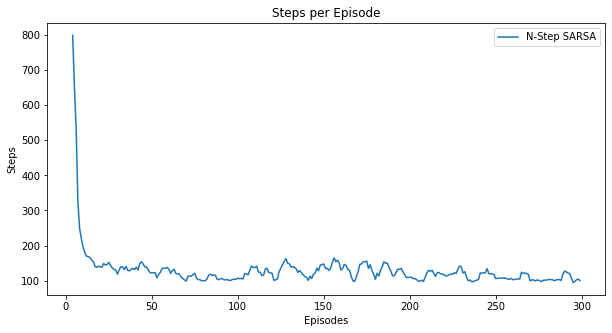

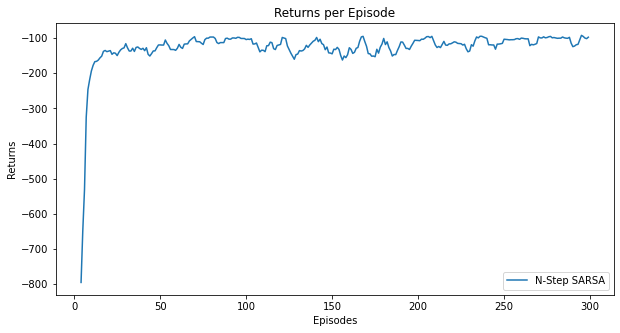

Episodes completed: 300 in 4.34s


In [98]:
# Fraction of the way we want to move towards target (we will set alpha = step_size/num_tilings)
step_size = 0.5

# Number of steps for bootstrapping (set to intermediate value)
n = 5

# number of episodes to run
num_episodes = 300

estimator = TilingLFA(env_mc, step_size=step_size, n=8, k=8, et=False)

# Record steps and returns for each episode to plot learning curves
episode_steps_list = []
episode_returns_list = []

start_time = timeit.default_timer()
for episode in notebook.tqdm(range(num_episodes)):
        episode_steps, episode_return = n_step_SARSA(n, env_mc, estimator, gamma=1, epsilon=0)
        episode_steps_list.append(episode_steps)
        episode_returns_list.append(episode_return)
        # print("\nEpisode: {} Return: {}".format(episode + 1, episode_return), end="")
elapsed_time = timeit.default_timer() - start_time

# plot_cost_to_go(env, estimator)
plot_steps_per_episode(episode_steps_list)
plot_episode_vs_return(episode_returns_list)
print('Episodes completed: {} in {:.2f}s'.format(num_episodes, elapsed_time))

Above shown are two graphs of N-Step SARSA for Mountain Car environment: 
- Returns per episode 
- Steps taken per episode to reach the goal state 

We also show that 300 espisodes show pretty good convergence for the mountain car environment and took around 4.34 seconds to run.

### Running episodic N-Step SARSA with Cartpole domain

In [110]:
# using MountainCar-v0 environment
env_acrobat = gym.make("Acrobot-v1")

env_acrobat._max_episode_steps = 2000

np.random.seed(37)

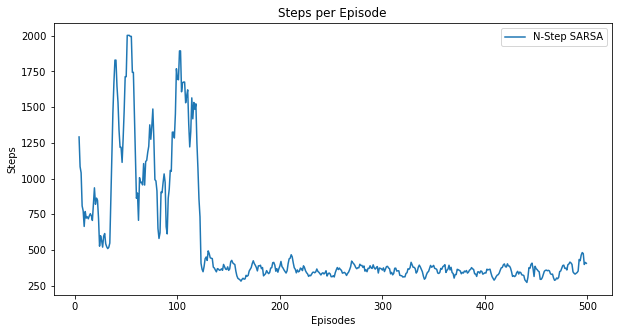

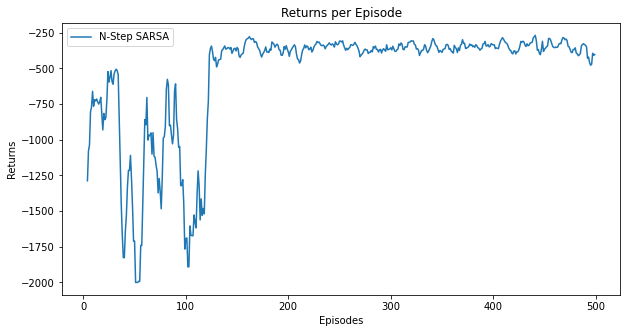

Episodes completed: 500 in 43.27s


In [111]:
# Fraction of the way we want to move towards target (we will set alpha = step_size/num_tilings)
step_size = 0.5

# Number of steps for bootstrapping (set to intermediate value)
n = 5

# number of episodes to run
num_episodes = 500

estimator = TilingLFA(env_acrobat, step_size=step_size, n=8, k=8, et=False)

# Record steps and returns for each episode to plot learning curves
episode_steps_list = []
episode_returns_list = []

start_time = timeit.default_timer()
for episode in notebook.tqdm(range(num_episodes)):
        episode_steps, episode_return = n_step_SARSA(n, env_acrobat, estimator, gamma=1, epsilon=0)
        episode_steps_list.append(episode_steps)
        episode_returns_list.append(episode_return)
        # print("\nEpisode: {} Return: {}".format(episode + 1, episode_return), end="")
elapsed_time = timeit.default_timer() - start_time

# plot_cost_to_go(env, estimator)
plot_steps_per_episode(episode_steps_list)
plot_episode_vs_return(episode_returns_list)
print('Episodes completed: {} in {:.2f}s'.format(num_episodes, elapsed_time))

Above shown are two graphs of N-Step SARSA for Acrobat environment: 
- Returns per episode 
- Steps taken per episode to reach the goal state 

We also show that 500 espisodes show pretty good convergence for the mountain car environment and took around 43.27 seconds to run.